In [1]:
# # convert /home/mvyas7/TRIM-QA/Summer-Research/CRAFT_NQ_TEST_1st_Stage_results.json to csv and save as training data.csv
# import os
# import pandas as pd

# # Load the JSON data
# json_file_path = "/home/mvyas7/TRIM-QA/Summer-Research/CRAFT_NQ_TEST_1st_Stage_results.json"
# with open(json_file_path, "r") as f:
#     json_data = json.load(f)

# # Convert JSON data to DataFrame
# df = pd.DataFrame.from_dict(json_data, orient="index")

# # Save DataFrame to CSV
# csv_file_path = "training_data.csv"
# df.to_csv(csv_file_path, index_label="query_id")


In [2]:
%pip install pandas

  Using cached pandas-2.3.1-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (91 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.3.1-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pandas]2m2/3 [pandas]
Note: you may need to restart the kernel to use updated packages.


In [3]:
#open traning_data.csv and display the row 88
import pandas as pd

df = pd.read_csv("training_data.csv")
print(df.iloc[88])

query_id                                                               88
Ranked_TableIds         ['List of Governors of Tennessee_6F926B692334A...
Original_Query          ['how old do you have to be to get a tatoo in ...
Qid_List                                  ['train_6794388697221948544_0']
Gold_Table_ID           ['Legal status of tattooing in the United Stat...
Gold Table Rank list                                                   []
Name: 88, dtype: object


In [4]:
# print first 2 queries from /home/mvyas7/TRIM-QA/Summer-Research/CRAFT_NQ_TEST_1st_Stage_results.json
import json

with open("/home/mvyas7/TRIM-QA/Summer-Research/CRAFT_NQ_TEST_1st_Stage_results.json", "r") as f:
    data = json.load(f)
    for i, (qid, query_data) in enumerate(data.items()):
        if i < 2:
            print(f"Query {i+1}: {query_data['Original_Query'][0]}")

Query 1: who has the most water in the world
Query 2: how many episodes of midnight texas season 1


In [5]:
# pipeline from scratch using hugging face splade embeddings and a neural ranking model
# first stage create triples from trainig and testing data 

# first lets create the triplets from training data 
# with following logic 
# 1. for each query in /home/mvyas7/TRIM-QA/Summer-Research/CRAFT_NQ_TEST_1st_Stage_results.json make a hashmap 
#    where for each query as key we store pos tbale id and 5 hard negatives table ids and original rank of the gold table 
#    and how are we gonna find the hard negatives are by following the logic that
#    if a table is ranked above the gold table, we consider it a hard negative
#    if there are no tables ranked above the gold table, we skip that query

# lets code step one 
import json
import ast
from typing import List, Dict

class triplet_formation:
    def __init__(self, train_file: str, tables_file: str):
        self.train_file = train_file # json file 
        self.map= {}
    
    def create_triplets(self) -> Dict:
        """Create triplets from training data"""
        with open(self.train_file, "r") as f:
            train_data = json.load(f)
            # print train data to check the structure
            # print(f"Loaded training data with {len(train_data)} queries.")
            # print json structure 
            # Debugging: Print the first 5 items to understand the structure
            # print("--- Sample Data Structure (First 5 Queries) ---")
            # for i, (qid, data) in enumerate(train_data.items()):
            #     if i >= 5:
            #         break
            #     print(f"Query {i+1} (QID: {qid}):")
            #     print(f"  Keys: {list(data.keys())}")
            #     print("-" * 40)
            # print("--- End of Sample Data ---\n")
            for qid, data in train_data.items():
                # print(f"Processing query {qid}...")
                # print(data)
                query = data.get("Original_Query")
                # print(f"Processing query {qid} with query: {query}")
                gold_table_id = data.get("Gold_Table_ID")
                ranked_tables_raw = data.get("Ranked_TableIds")
                # print few ranked tables
                # print(ranked_tables_raw[:5])
                gold_rank_list = data.get("Gold Table Rank list")
                if not gold_rank_list:
                    print(f"Skipping query {qid} due to empty gold table rank list.")
                    continue
                gold_table_rank= data.get("Gold Table Rank list")[0]
                # print(f"Gold Table ID: {gold_table_id}, Gold Table Rank: {gold_table_rank}")
                # print(f"Gold Table ID: {gold_table_id}, Ranked Tables Raw: {ranked_tables_raw}")
                if not gold_table_id or not ranked_tables_raw:
                    print(f"Skipping query {qid} due to missing gold table ID or ranked tables.")
                    continue
                # else:
                #     print(f"Gold Table ID: {gold_table_id}, Ranked Tables: {ranked_tables_raw}")

                # The ranked list might be a string that needs parsing
                if isinstance(ranked_tables_raw, str):
                    try:
                        ranked_tables = ast.literal_eval(ranked_tables_raw)
                    except (ValueError, SyntaxError):
                        continue
                else:
                    ranked_tables = ranked_tables_raw

                # Get hard negatives (tables ranked above the gold table)
                if gold_table_rank <=3:
                    hard_negatives = [table_id for table_id in ranked_tables[:gold_table_rank+1]]
                else:
                    hard_negatives = [table_id for table_id in ranked_tables[:4]]

                # If there are no hard negatives, skip this query
                if not hard_negatives:
                    continue

                # Store the information in the map
                self.map[qid] = {
                    "query": query,
                    "positive_table_id": gold_table_id,
                    "rank": gold_table_rank,
                    "hard_negatives": hard_negatives[:3]  # Max 3 hard negatives
                }
            # The rest of the original code seems to be creating a different kind of triplet list,
            # which might be from an older version. We can remove it or adapt it.
            # For now, let's just return the created map as it fulfills the user's request.
            return self.map

def main():
    triplet_creator = triplet_formation(
        train_file="/home/mvyas7/TRIM-QA/Summer-Research/CRAFT_NQ_TEST_1st_Stage_results.json",
        tables_file="/home/mvyas7/TRIM-QA/Summer-Research/nq_tables/tables/tables.jsonl"
    )
    
    triplets = triplet_creator.create_triplets()
    
    # Save triplets to a file
    with open("triplets.json", "w") as f:
        json.dump(triplets, f, indent=4)
    
    print(f"Created {len(triplets)} triplets.")

# execute main function
if __name__ == "__main__":
    main()

Skipping query 88 due to empty gold table rank list.
Skipping query 156 due to empty gold table rank list.
Skipping query 529 due to empty gold table rank list.
Skipping query 568 due to empty gold table rank list.
Skipping query 771 due to empty gold table rank list.
Skipping query 964 due to empty gold table rank list.
Skipping query 1004 due to empty gold table rank list.
Skipping query 1005 due to empty gold table rank list.
Skipping query 1248 due to empty gold table rank list.
Skipping query 1291 due to empty gold table rank list.
Skipping query 1298 due to empty gold table rank list.
Skipping query 1346 due to empty gold table rank list.
Skipping query 1438 due to empty gold table rank list.
Skipping query 1577 due to empty gold table rank list.
Skipping query 1673 due to empty gold table rank list.
Skipping query 1867 due to empty gold table rank list.
Skipping query 1966 due to empty gold table rank list.
Skipping query 2122 due to empty gold table rank list.
Skipping query 22

In [6]:
# print any one triplet
import json
with open("triplets.json", "r") as f:
    triplets = json.load(f)
    # print the first triplet
    first_triplet = list(triplets.items())[0]
    print(f"First Triplet: {first_triplet}")
    # print the query, positive table id, rank and hard negatives
    print(f"Query: {first_triplet[1]['query']}")
    print(f"Positive Table ID: {first_triplet[1]['positive_table_id']}")
    print(f"Rank: {first_triplet[1]['rank']}")
    print(f"Hard Negatives: {first_triplet[1]['hard_negatives']}")

First Triplet: ('0', {'query': ['who has the most water in the world'], 'positive_table_id': ['List of countries by total renewable water resources_BD944C2B2ACBEFE9'], 'rank': 121, 'hard_negatives': ['World Water Day_2067CD5D118A0D0E', 'Water intoxication_E3E2D4951725EA61', 'The Shape of Water_3CF64C600542F744']})
Query: ['who has the most water in the world']
Positive Table ID: ['List of countries by total renewable water resources_BD944C2B2ACBEFE9']
Rank: 121
Hard Negatives: ['World Water Day_2067CD5D118A0D0E', 'Water intoxication_E3E2D4951725EA61', 'The Shape of Water_3CF64C600542F744']


In [5]:
%pip install numpy torch transformers faiss-cpu tqdm

  Using cached faiss-cpu-1.7.4.tar.gz (57 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  ERROR: Command errored out with exit status 1:
   command: /home/mvyas7/TRIM-QA/Summer-Research/summer-research-venv/bin/python /home/mvyas7/TRIM-QA/Summer-Research/summer-research-venv/lib64/python3.6/site-packages/pip/_vendor/pep517/in_process/_in_process.py build_wheel /tmp/tmpmkh1s48i
       cwd: /tmp/pip-install-5zdxc_rz/faiss-cpu_d0634108ec354279ad92fd2a4a61cdb9
  Complete output (9 lines):
  running bdist_wheel
  running build
  running build_py
  running build_ext
  building 'faiss._swigfaiss' extension
  swigging faiss/faiss/python/swigfaiss.i to faiss/faiss/python/swigfaiss_wrap.cpp
  swig -python -c++ -Doverride= -I/usr/local/include -Ifaiss -doxygen -DSWIGWORDSIZE64 -module swigfaiss -o faiss/faiss/python/swigfaiss_wrap.cpp faiss/faiss/python/swigfaiss.i
  unable to execute 'swig': No such file

In [14]:
import json
import numpy as np
from typing import Dict, List
from transformers import AutoTokenizer, AutoModel
import torch
import faiss
from tqdm import tqdm

class SpladeEmbedding:
    def __init__(self, model_name: str, tables_file: str):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(self.device)
        self.model.eval()
        
        self.tables_file = tables_file
        self.table_map = self.load_tables()
        print(f"Loaded {len(self.table_map)} tables from {tables_file}")

    def load_tables(self) -> Dict[str, Dict]:
        """Load tables from the JSONL file into a dictionary."""
        table_map = {}
        with open(self.tables_file, "r") as f:
            for line in tqdm(f, desc="Loading tables"):
                if line.strip():
                    table_data = json.loads(line.strip())
                    table_id = table_data.get("tableId")
                    if table_id:
                        table_map[table_id] = table_data
        return table_map

    def extract_table_content(self, table_data: Dict) -> str:
        """Extract complete table content as text."""
        content_parts = []
        
        # Add document title
        if 'documentTitle' in table_data:
            content_parts.append(f"Title: {table_data['documentTitle']}")
        
        # Add table caption if exists
        if 'tableCaption' in table_data:
            content_parts.append(f"Caption: {table_data['tableCaption']}")
        
        # Add column headers
        if 'columns' in table_data and table_data['columns']:
            headers = [col.get('text', '') for col in table_data['columns']]
            content_parts.append(f"Headers: {' | '.join(headers)}")
        
        # Add table rows
        if 'rows' in table_data and table_data['rows']:
            for i, row in enumerate(table_data['rows']):  
                if 'cells' in row:
                    cells = [cell.get('text', '') for cell in row['cells']]
                    content_parts.append(f"Row {i+1}: {' | '.join(cells)}")
        
        return " ".join(content_parts)

    def create_splade_embedding(self, text: str) -> np.ndarray:
        """Create SPLADE embedding for the given text."""
        # Tokenize the text
        inputs = self.tokenizer(
            text, 
            return_tensors="pt", 
            truncation=True, 
            padding=True, 
            max_length=512
        ).to(self.device)
        
        with torch.no_grad():
            # Get model outputs
            outputs = self.model(**inputs)
            
            # Create SPLADE representation
            # Apply ReLU and log(1 + x) transformation for sparsity
            logits = outputs.last_hidden_state
            splade_rep = torch.log(1 + torch.relu(logits))
            
            # Max pooling over sequence length
            splade_embedding = torch.max(splade_rep, dim=1)[0]
            
        return splade_embedding.cpu().numpy()

    def create_embeddings_for_triplets(self, triplets: Dict) -> Dict:
        """Create embeddings for all queries and tables in triplets."""
        embeddings_data = {}
        
        print("Creating embeddings for triplets...")
        
        for qid, data in tqdm(triplets.items(), desc="Processing triplets"):
            pos_table_id = data["positive_table_id"]
            hard_negatives = data["hard_negatives"]
            query = data.get("query")
            
            # Initialize query data
            embeddings_data[qid] = {
                "positive_table_id": pos_table_id,
                "hard_negatives": hard_negatives,
                "query": query,
                "query_embedding": None,
                "positive_embedding": None,
                "negative_embeddings": [],
                "positive_content": None,
                "negative_contents": []
            }
            
            # Process positive table
            current_pos_table_id = pos_table_id[0] if isinstance(pos_table_id, list) else pos_table_id
            if current_pos_table_id in self.table_map:
                pos_table_content = self.extract_table_content(self.table_map[current_pos_table_id])
                pos_embedding = self.create_splade_embedding(pos_table_content)
                
                embeddings_data[qid]["positive_embedding"] = pos_embedding
                embeddings_data[qid]["positive_content"] = pos_table_content[:200] + "..."
            else:
                print(f"Warning: Positive table {current_pos_table_id} not found in table map")
                continue
            
            # Process negative tables
            for neg_table_id in hard_negatives:
                if neg_table_id in self.table_map:
                    neg_table_content = self.extract_table_content(self.table_map[neg_table_id])
                    neg_embedding = self.create_splade_embedding(neg_table_content)
                    
                    embeddings_data[qid]["negative_embeddings"].append(neg_embedding)
                    embeddings_data[qid]["negative_contents"].append(neg_table_content[:200] + "...")
                else:
                    print(f"Warning: Negative table {neg_table_id} not found in table map")
            
            # process the query
            if query:
                query_embedding = self.create_splade_embedding(query)
                embeddings_data[qid]["query_embedding"] = query_embedding
            else:
                print(f"Warning: Query for {qid} is empty or not found")
        return embeddings_data

    def create_faiss_index(self, embeddings_data: Dict) -> tuple:
        """Create separate FAISS indices for positive, negative, and query embeddings."""
        first_embedding = None
        for qid, data in embeddings_data.items():
            if data["positive_embedding"] is not None:
                first_embedding = data["positive_embedding"]
                break
        
        if first_embedding is None:
            raise ValueError("No valid embeddings found")
        
        embedding_dim = first_embedding.shape[1]
        print(f"Embedding dimension: {embedding_dim}")
        
        positive_index = faiss.IndexFlatIP(embedding_dim)
        negative_index = faiss.IndexFlatIP(embedding_dim)
        query_index = faiss.IndexFlatIP(embedding_dim)
        
        positive_embeddings, negative_embeddings, query_embeddings = [], [], []
        positive_metadata, negative_metadata, query_metadata = [], [], []

        for qid, data in embeddings_data.items():
            if data["positive_embedding"] is not None:
                positive_embeddings.append(data["positive_embedding"])
                positive_metadata.append({"qid": qid, "table_id": data["positive_table_id"], "query": data["query"]})
            
            for i, neg_emb in enumerate(data["negative_embeddings"]):
                negative_embeddings.append(neg_emb)
                negative_metadata.append({"qid": qid, "table_id": data["hard_negatives"][i], "query": data["query"]})
            
            if data["query_embedding"] is not None:
                query_embeddings.append(data["query_embedding"])
                query_metadata.append({"qid": qid, "query": data["query"]})
        
        if positive_embeddings:
            positive_index.add(np.vstack(positive_embeddings))
            print(f"Added {len(positive_embeddings)} positive embeddings to index")
        
        if negative_embeddings:
            negative_index.add(np.vstack(negative_embeddings))
            print(f"Added {len(negative_embeddings)} negative embeddings to index")
            
        if query_embeddings:
            query_index.add(np.vstack(query_embeddings))
            print(f"Added {len(query_embeddings)} query embeddings to index")
        
        return positive_index, negative_index, query_index, positive_metadata, negative_metadata, query_metadata

    def save_embeddings_and_indices(self, embeddings_data: Dict, positive_index: faiss.Index, 
                                   negative_index: faiss.Index, query_index: faiss.Index, 
                                   positive_metadata: List, negative_metadata: List, 
                                   query_metadata: List):
        """Save embeddings, indices, and metadata to files."""
        
        embeddings_to_save = {}
        for qid, data in embeddings_data.items():
            embeddings_to_save[qid] = {
                "positive_table_id": data["positive_table_id"],
                "hard_negatives": data["hard_negatives"],
                "query": data["query"],
                "positive_content": data["positive_content"],
                "negative_contents": data["negative_contents"]
            }
        
        with open("triplet_embeddings_data.json", "w") as f:
            json.dump(embeddings_to_save, f, indent=2)
        
        faiss.write_index(positive_index, "positive_tables_index.faiss")
        faiss.write_index(negative_index, "negative_tables_index.faiss")
        faiss.write_index(query_index, "queries_index.faiss")
        
        with open("positive_metadata.json", "w") as f:
            json.dump(positive_metadata, f, indent=2)
        
        with open("negative_metadata.json", "w") as f:
            json.dump(negative_metadata, f, indent=2)
            
        with open("query_metadata.json", "w") as f:
            json.dump(query_metadata, f, indent=2)
        
        print("All embeddings, indices, and metadata saved successfully!")
        print(f"Files created:")
        print(f"- triplet_embeddings_data.json")
        print(f"- positive_tables_index.faiss")
        print(f"- negative_tables_index.faiss")
        print(f"- queries_index.faiss")
        print(f"- positive_metadata.json")
        print(f"- negative_metadata.json")
        print(f"- query_metadata.json")

def main():
    print("Loading triplets...")
    with open("triplets.json", "r") as f:
        triplets = json.load(f)
    
    print(f"Loaded {len(triplets)} triplets")
    
    print("Initializing SPLADE embedding model...")
    splade_embedding = SpladeEmbedding(
        model_name="naver/splade-cocondenser-ensembledistil",
        tables_file="/home/mvyas7/TRIM-QA/Summer-Research/nq_tables/tables/tables.jsonl"
    )
    
    embeddings_data = splade_embedding.create_embeddings_for_triplets(triplets)
    
    print("Creating FAISS indices...")
    try:
        positive_index, negative_index, query_index, positive_metadata, negative_metadata, query_metadata = splade_embedding.create_faiss_index(embeddings_data)
    except ValueError as e:
        print(f"An error occurred during FAISS index creation: {e}")
        raise e
    
    splade_embedding.save_embeddings_and_indices(
        embeddings_data, positive_index, negative_index, query_index,
        positive_metadata, negative_metadata, query_metadata
    )
    
    print("Process completed successfully!")
    print(f"Summary:")
    print(f"- Total triplets processed: {len(embeddings_data)}")
    print(f"- Positive table embeddings: {positive_index.ntotal}")
    print(f"- Negative table embeddings: {negative_index.ntotal}")
    print(f"- Query embeddings: {query_index.ntotal}")

if __name__ == "__main__":
    main()


Loading triplets...
Loaded 9530 triplets
Initializing SPLADE embedding model...
Using device: cuda


/home/mvyas7/miniconda3/envs/summer-research-conda/lib/python3.9/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertModel were not initialized from the model checkpoint at naver/splade-cocondenser-ensembledistil and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Loading tables: 169898it [00:29, 5847.26it/s] 


Loaded 169898 tables from /home/mvyas7/TRIM-QA/Summer-Research/nq_tables/tables/tables.jsonl
Creating embeddings for triplets...


Processing triplets: 100%|██████████| 9530/9530 [06:30<00:00, 24.40it/s]


Creating FAISS indices...
Embedding dimension: 768
Added 9530 positive embeddings to index
Added 25625 negative embeddings to index
Added 9530 query embeddings to index
All embeddings, indices, and metadata saved successfully!
Files created:
- triplet_embeddings_data.json
- positive_tables_index.faiss
- negative_tables_index.faiss
- queries_index.faiss
- positive_metadata.json
- negative_metadata.json
- query_metadata.json
Process completed successfully!
Summary:
- Total triplets processed: 9530
- Positive table embeddings: 9530
- Negative table embeddings: 25625
- Query embeddings: 9530


In [12]:
%pip install --upgrade openai

  Using cached openai-0.10.5.tar.gz (157 kB)
  Preparing metadata (setup.py) ... done
  Using cached openai-0.10.4.tar.gz (157 kB)
  Preparing metadata (setup.py) ... done
  Using cached openai-0.10.3.tar.gz (157 kB)
  Preparing metadata (setup.py) ... done
  Using cached openai-0.10.2.tar.gz (156 kB)
  Preparing metadata (setup.py) ... done
  Using cached openai-0.10.1.tar.gz (155 kB)
  Preparing metadata (setup.py) ... done
  Using cached openai-0.10.0.tar.gz (155 kB)
  Preparing metadata (setup.py) ... done
  Using cached openai-0.9.4.tar.gz (156 kB)
  Preparing metadata (setup.py) ... done
  Using cached openai-0.9.3.tar.gz (155 kB)
  Preparing metadata (setup.py) ... done
  Using cached openai-0.9.2.tar.gz (155 kB)
  Preparing metadata (setup.py) ... done
  Using cached openai-0.9.1.tar.gz (156 kB)
  Preparing metadata (setup.py) ... done
  Using cached openai-0.9.0.tar.gz (155 kB)
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated pac

In [7]:
%pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [11]:
import json
import numpy as np
from typing import Dict, List
import torch
import faiss
from tqdm import tqdm
import requests
import os
from openai import OpenAI
from transformers import AutoTokenizer, AutoModel
from dotenv import load_dotenv
load_dotenv()

class EnhancedEmbedding:
    def __init__(self, model_name: str, tables_file: str, embedding_dim: int = 1536):
        """
        Initialize the embedding model.
        
        Args:
            model_name: "openai", "e5", or others
            tables_file: Path to the JSONL file containing tables
            embedding_dim: Dimension of embeddings (1536 for OpenAI, 1024 for E5-large)
        """
        self.model_name = model_name.lower()
        self.embedding_dim = embedding_dim
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
        # Initialize the appropriate model
        if self.model_name == "openai":
            # OpenAI API setup
            self.api_key = os.environ.get("OPENAI_API_KEY")
            if not self.api_key:
                raise ValueError("OpenAI API key not found. Set OPENAI_API_KEY environment variable.")
            self.openai_client = OpenAI(api_key=self.api_key)
        elif self.model_name == "e5":
            # Load E5 embedding model
            model_path = "intfloat/e5-large-v2"
            print(f"Loading E5 model from {model_path}...")
            self.tokenizer = AutoTokenizer.from_pretrained(model_path)
            self.model = AutoModel.from_pretrained(model_path).to(self.device)
            self.model.eval()
        elif self.model_name == "jina-v2":
            # Load Jina-v2 embedding model
            self.tokenizer = AutoTokenizer.from_pretrained("jinaai/jina-embeddings-v2")
            self.model = AutoModel.from_pretrained("jinaai/jina-embeddings-v2").to(self.device)
            self.model.eval()
        else:
            raise ValueError(f"Unsupported model name: {model_name}. Use 'openai', 'e5', or 'jina-v2'.")
        
        # Load tables
        self.tables_file = tables_file
        self.table_map = self.load_tables()
        print(f"Loaded {len(self.table_map)} tables from {tables_file}")

    def load_tables(self) -> Dict[str, Dict]:
        """Load tables from the JSONL file into a dictionary."""
        table_map = {}
        with open(self.tables_file, "r") as f:
            for line in tqdm(f, desc="Loading tables"):
                if line.strip():
                    table_data = json.loads(line.strip())
                    table_id = table_data.get("tableId")
                    if table_id:
                        table_map[table_id] = table_data
        return table_map

    def extract_table_content(self, table_data: Dict) -> str:
        """Extract complete table content as text."""
        content_parts = []
        
        # Add document title
        if 'documentTitle' in table_data:
            content_parts.append(f"Title: {table_data['documentTitle']}")
        
        # Add table caption if exists
        if 'tableCaption' in table_data:
            content_parts.append(f"Caption: {table_data['tableCaption']}")
        
        # Add column headers
        if 'columns' in table_data and table_data['columns']:
            headers = [col.get('text', '') for col in table_data['columns']]
            content_parts.append(f"Headers: {' | '.join(headers)}")
        
        # Add table rows
        if 'rows' in table_data and table_data['rows']:
            for i, row in enumerate(table_data['rows']):  
                if 'cells' in row:
                    cells = [cell.get('text', '') for cell in row['cells']]
                    content_parts.append(f"Row {i+1}: {' | '.join(cells)}")
        
        return " ".join(content_parts)

    def create_embedding(self, text: str) -> np.ndarray:
        """Create embedding for the given text using the selected model."""
        if self.model_name == "openai":
            # Use OpenAI's embedding API
            try:
                response = self.openai_client.embeddings.create(
                    input=text,
                    model="text-embedding-3-small"
                )
                embedding = response.data[0].embedding
                return np.array(embedding, dtype=np.float32)
            except Exception as e:
                print(f"Error creating OpenAI embedding: {e}")
                return np.zeros(self.embedding_dim, dtype=np.float32)
        
        elif self.model_name == "e5":
            # Use E5 model 
            try:
                # E5 models use specific prefixes for different types of text
                if text.startswith("Find tables relevant to this query:"):
                    # For queries, use the "query: " prefix
                    text = "query: " + text[len("Find tables relevant to this query:"):].strip()
                else:
                    # For passages/tables, use the "passage: " prefix
                    text = "passage: " + text
                
                inputs = self.tokenizer(
                    text, 
                    return_tensors="pt", 
                    truncation=True, 
                    padding=True, 
                    max_length=512
                ).to(self.device)
                
                with torch.no_grad():
                    outputs = self.model(**inputs)
                    # For E5 models, use the CLS token embedding (first token)
                    embedding = outputs.last_hidden_state[:, 0].cpu().numpy()
                
                # Normalize the embedding (important for E5)
                embedding = embedding / np.linalg.norm(embedding, axis=1, keepdims=True)
                return embedding[0]
            except Exception as e:
                print(f"Error creating E5 embedding: {e}")
                return np.zeros(self.embedding_dim, dtype=np.float32)
                
        elif self.model_name == "jina-v2":
            # Use Jina-v2 model
            try:
                inputs = self.tokenizer(
                    text, 
                    return_tensors="pt", 
                    truncation=True, 
                    padding=True, 
                    max_length=512
                ).to(self.device)
                
                with torch.no_grad():
                    outputs = self.model(**inputs)
                    # Mean pooling - take average of all token embeddings
                    embedding = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
                
                return embedding[0]
            except Exception as e:
                print(f"Error creating Jina-v2 embedding: {e}")
                return np.zeros(self.embedding_dim, dtype=np.float32)

    def create_embeddings_for_triplets(self, triplets: Dict) -> Dict:
        """Create embeddings for all queries and tables in triplets."""
        embeddings_data = {}
        
        print("Creating embeddings for triplets...")
        
        for qid, data in tqdm(triplets.items(), desc="Processing triplets"):
            pos_table_id = data["positive_table_id"]
            hard_negatives = data["hard_negatives"]
            query = data.get("query")
            
            # Initialize query data
            embeddings_data[qid] = {
                "positive_table_id": pos_table_id,
                "hard_negatives": hard_negatives,
                "query": query,
                "query_embedding": None,
                "positive_embedding": None,
                "negative_embeddings": [],
                "positive_content": None,
                "negative_contents": []
            }
            
            # Process positive table
            current_pos_table_id = pos_table_id[0] if isinstance(pos_table_id, list) else pos_table_id
            if current_pos_table_id in self.table_map:
                pos_table_content = self.extract_table_content(self.table_map[current_pos_table_id])
                pos_embedding = self.create_embedding(pos_table_content)
                
                embeddings_data[qid]["positive_embedding"] = pos_embedding
                embeddings_data[qid]["positive_content"] = pos_table_content[:200] + "..."
            else:
                print(f"Warning: Positive table {current_pos_table_id} not found in table map")
                continue
            
            # Process negative tables
            for neg_table_id in hard_negatives:
                if neg_table_id in self.table_map:
                    neg_table_content = self.extract_table_content(self.table_map[neg_table_id])
                    neg_embedding = self.create_embedding(neg_table_content)
                    
                    embeddings_data[qid]["negative_embeddings"].append(neg_embedding)
                    embeddings_data[qid]["negative_contents"].append(neg_table_content[:200] + "...")
                else:
                    print(f"Warning: Negative table {neg_table_id} not found in table map")
            
            # Process the query
            if query:
                # Format query differently depending on model
                if self.model_name == "openai":
                    query_prompt = f"Find tables relevant to this query: {query}"
                    query_embedding = self.create_embedding(query_prompt)
                elif self.model_name == "e5":
                    query_prompt = f"Find tables relevant to this query: {query}"
                    query_embedding = self.create_embedding(query_prompt)
                else:
                    query_embedding = self.create_embedding(query)
                    
                embeddings_data[qid]["query_embedding"] = query_embedding
            else:
                print(f"Warning: Query for {qid} is empty or not found")
                
        return embeddings_data

    # No changes needed for the rest of the methods
    def create_faiss_index(self, embeddings_data: Dict) -> tuple:
        """Create separate FAISS indices for positive, negative, and query embeddings."""
        first_embedding = None
        for qid, data in embeddings_data.items():
            if data["positive_embedding"] is not None:
                first_embedding = data["positive_embedding"]
                break
        
        if first_embedding is None:
            raise ValueError("No valid embeddings found")
        
        embedding_dim = first_embedding.shape[0]
        print(f"Embedding dimension: {embedding_dim}")
        
        # Create FAISS indices
        positive_index = faiss.IndexFlatIP(embedding_dim)
        negative_index = faiss.IndexFlatIP(embedding_dim)
        query_index = faiss.IndexFlatIP(embedding_dim)
        
        positive_embeddings, negative_embeddings, query_embeddings = [], [], []
        positive_metadata, negative_metadata, query_metadata = [], [], []

        for qid, data in embeddings_data.items():
            if data["positive_embedding"] is not None:
                positive_embeddings.append(data["positive_embedding"])
                positive_metadata.append({"qid": qid, "table_id": data["positive_table_id"], "query": data["query"]})
            
            for i, neg_emb in enumerate(data["negative_embeddings"]):
                negative_embeddings.append(neg_emb)
                negative_metadata.append({"qid": qid, "table_id": data["hard_negatives"][i], "query": data["query"]})
            
            if data["query_embedding"] is not None:
                query_embeddings.append(data["query_embedding"])
                query_metadata.append({"qid": qid, "query": data["query"]})
        
        if positive_embeddings:
            positive_index.add(np.vstack(positive_embeddings))
            print(f"Added {len(positive_embeddings)} positive embeddings to index")
        
        if negative_embeddings:
            negative_index.add(np.vstack(negative_embeddings))
            print(f"Added {len(negative_embeddings)} negative embeddings to index")
            
        if query_embeddings:
            query_index.add(np.vstack(query_embeddings))
            print(f"Added {len(query_embeddings)} query embeddings to index")
        
        return positive_index, negative_index, query_index, positive_metadata, negative_metadata, query_metadata

    def save_embeddings_and_indices(self, embeddings_data: Dict, positive_index: faiss.Index, 
                                   negative_index: faiss.Index, query_index: faiss.Index, 
                                   positive_metadata: List, negative_metadata: List, 
                                   query_metadata: List):
        """Save embeddings, indices, and metadata to files."""
        # Update model prefix to include the specific model used
        if self.model_name == "openai":
            model_prefix = "openai"
        elif self.model_name == "e5":
            model_prefix = "e5"
        elif self.model_name == "jina-v2":
            model_prefix = "jina"
        else:
            model_prefix = self.model_name
        
        embeddings_to_save = {}
        for qid, data in embeddings_data.items():
            embeddings_to_save[qid] = {
                "positive_table_id": data["positive_table_id"],
                "hard_negatives": data["hard_negatives"],
                "query": data["query"],
                "positive_content": data["positive_content"],
                "negative_contents": data["negative_contents"]
            }
        
        with open(f"{model_prefix}_triplet_embeddings_data.json", "w") as f:
            json.dump(embeddings_to_save, f, indent=2)
        
        faiss.write_index(positive_index, f"{model_prefix}_positive_tables_index.faiss")
        faiss.write_index(negative_index, f"{model_prefix}_negative_tables_index.faiss")
        faiss.write_index(query_index, f"{model_prefix}_queries_index.faiss")
        
        with open(f"{model_prefix}_positive_metadata.json", "w") as f:
            json.dump(positive_metadata, f, indent=2)
        
        with open(f"{model_prefix}_negative_metadata.json", "w") as f:
            json.dump(negative_metadata, f, indent=2)
            
        with open(f"{model_prefix}_query_metadata.json", "w") as f:
            json.dump(query_metadata, f, indent=2)
        
        print("All embeddings, indices, and metadata saved successfully!")
        print(f"Files created:")
        print(f"- {model_prefix}_triplet_embeddings_data.json")
        print(f"- {model_prefix}_positive_tables_index.faiss")
        print(f"- {model_prefix}_negative_tables_index.faiss")
        print(f"- {model_prefix}_queries_index.faiss")
        print(f"- {model_prefix}_positive_metadata.json")
        print(f"- {model_prefix}_negative_metadata.json")
        print(f"- {model_prefix}_query_metadata.json")

def main_e5():
    """Run the embedding pipeline using E5 embeddings"""
    print("Loading triplets...")
    with open("triplets.json", "r") as f:
        triplets = json.load(f)
    
    print(f"Loaded {len(triplets)} triplets")
    
    print("Initializing E5 embedding model...")
    embedding_model = EnhancedEmbedding(
        model_name="e5",
        tables_file="/home/mvyas7/TRIM-QA/Summer-Research/nq_tables/tables/tables.jsonl",
        embedding_dim=1024  # E5-large-v2 uses 1024 dimensions
    )
    
    embeddings_data = embedding_model.create_embeddings_for_triplets(triplets)
    
    print("Creating FAISS indices...")
    try:
        positive_index, negative_index, query_index, positive_metadata, negative_metadata, query_metadata = embedding_model.create_faiss_index(embeddings_data)
    except ValueError as e:
        print(f"An error occurred during FAISS index creation: {e}")
        raise e
    
    embedding_model.save_embeddings_and_indices(
        embeddings_data, positive_index, negative_index, query_index,
        positive_metadata, negative_metadata, query_metadata
    )
    
    print("Process completed successfully!")
    print(f"Summary:")
    print(f"- Total triplets processed: {len(embeddings_data)}")
    print(f"- Positive table embeddings: {positive_index.ntotal}")
    print(f"- Negative table embeddings: {negative_index.ntotal}")
    print(f"- Query embeddings: {query_index.ntotal}")

if __name__ == "__main__":
    main_e5()

Loading triplets...
Loaded 9530 triplets
Initializing E5 embedding model...
Using device: cuda
Loading E5 model from intfloat/e5-large-v2...


Loading tables: 169898it [00:19, 8883.64it/s] 


Loaded 169898 tables from /home/mvyas7/TRIM-QA/Summer-Research/nq_tables/tables/tables.jsonl
Creating embeddings for triplets...


Processing triplets:   0%|          | 0/9530 [00:00<?, ?it/s]/home/mvyas7/TRIM-QA/Summer-Research/summer-research-venv3/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Processing triplets: 100%|██████████| 9530/9530 [13:10<00:00, 12.06it/s]


Creating FAISS indices...
Embedding dimension: 1024
Added 9530 positive embeddings to index
Added 25625 negative embeddings to index
Added 9530 query embeddings to index
All embeddings, indices, and metadata saved successfully!
Files created:
- e5_triplet_embeddings_data.json
- e5_positive_tables_index.faiss
- e5_negative_tables_index.faiss
- e5_queries_index.faiss
- e5_positive_metadata.json
- e5_negative_metadata.json
- e5_query_metadata.json
Process completed successfully!
Summary:
- Total triplets processed: 9530
- Positive table embeddings: 9530
- Negative table embeddings: 25625
- Query embeddings: 9530


In [15]:
%pip install --upgrade openai>=1.0.0

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import openai
# print version of openai
print(f"OpenAI version: {openai.__version__}")

In [7]:
def main_openai():
    print("Loading triplets...")
    with open("triplets.json", "r") as f:
        triplets = json.load(f)
    
    print(f"Loaded {len(triplets)} triplets")
    
    # Make sure to set OPENAI_API_KEY environment variable
    print("Initializing OpenAI embedding model...")
    embedding_model = EnhancedEmbedding(
        model_name="openai",
        tables_file="/home/mvyas7/TRIM-QA/Summer-Research/nq_tables/tables/tables.jsonl",
        embedding_dim=1536  # OpenAI text-embedding-3-small is 1536 dimensions
    )
    
    embeddings_data = embedding_model.create_embeddings_for_triplets(triplets)
    
    print("Creating FAISS indices...")
    try:
        positive_index, negative_index, query_index, positive_metadata, negative_metadata, query_metadata = embedding_model.create_faiss_index(embeddings_data)
    except ValueError as e:
        print(f"An error occurred during FAISS index creation: {e}")
        raise e
    
    embedding_model.save_embeddings_and_indices(
        embeddings_data, positive_index, negative_index, query_index,
        positive_metadata, negative_metadata, query_metadata
    )
    
    print("Process completed successfully!")
    print(f"Summary:")
    print(f"- Total triplets processed: {len(embeddings_data)}")
    print(f"- Positive table embeddings: {positive_index.ntotal}")
    print(f"- Negative table embeddings: {negative_index.ntotal}")
    print(f"- Query embeddings: {query_index.ntotal}")

In [ ]:
def main_jina():
    print("Loading triplets...")
    with open("triplets.json", "r") as f:
        triplets = json.load(f)
    
    print(f"Loaded {len(triplets)} triplets")
    
    print("Initializing Jina AI embedding model...")
    embedding_model = EnhancedEmbedding(
        model_name="jina-v2",
        tables_file="/home/mvyas7/TRIM-QA/Summer-Research/nq_tables/tables/tables.jsonl",
        embedding_dim=768  # Jina-v2 is 768 dimensions
    )
    
    embeddings_data = embedding_model.create_embeddings_for_triplets(triplets)
    
    print("Creating FAISS indices...")
    try:
        positive_index, negative_index, query_index, positive_metadata, negative_metadata, query_metadata = embedding_model.create_faiss_index(embeddings_data)
    except ValueError as e:
        print(f"An error occurred during FAISS index creation: {e}")
        raise e
    
    embedding_model.save_embeddings_and_indices(
        embeddings_data, positive_index, negative_index, query_index,
        positive_metadata, negative_metadata, query_metadata
    )
    
    print("Process completed successfully!")
    print(f"Summary:")
    print(f"- Total triplets processed: {len(embeddings_data)}")
    print(f"- Positive table embeddings: {positive_index.ntotal}")
    print(f"- Negative table embeddings: {negative_index.ntotal}")
    print(f"- Query embeddings: {query_index.ntotal}")

Loading FAISS indices...
Loading metadata...
Extracting embeddings from positive index (9530 vectors)...
Extracting embeddings from negative index (25625 vectors)...
Positive embeddings shape: (9530, 1024)
Negative embeddings shape: (25625, 1024)
Sampling 1000 positive embeddings for visualization
Sampling 1000 negative embeddings for visualization
Applying PCA for visualization...
Applying t-SNE for visualization...


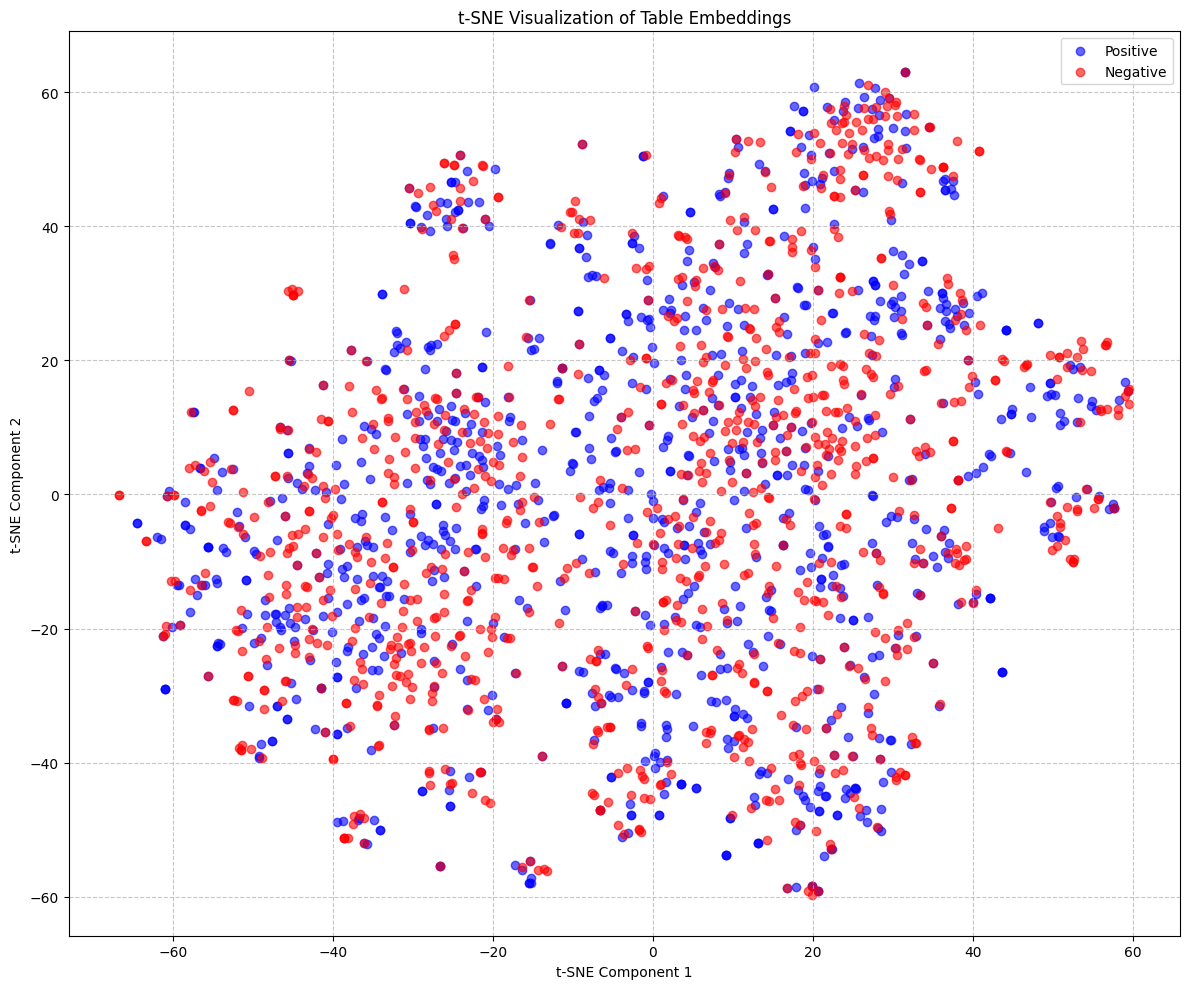


Embedding Statistics:
Average L2 norm - Positive: 1.0000
Average L2 norm - Negative: 1.0000
Average cosine similarity between positive embeddings: 0.6687
Average cosine similarity between negative embeddings: 0.6621
Average cosine similarity between positive and negative embeddings: 0.6611


In [3]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import faiss
import json
from sklearn.metrics.pairwise import cosine_similarity

# Visualize embeddings from FAISS indices
import matplotlib.pyplot as plt

# Load the FAISS indices
print("Loading FAISS indices...")
positive_index = faiss.read_index("/home/mvyas7/TRIM-QA/Summer-Research/e5_positive_tables_index.faiss")
negative_index = faiss.read_index("/home/mvyas7/TRIM-QA/Summer-Research/e5_negative_tables_index.faiss")

# Load metadata for context
print("Loading metadata...")
with open("positive_metadata.json", "r") as f:
    positive_metadata = json.load(f)
with open("negative_metadata.json", "r") as f:
    negative_metadata = json.load(f)

# Extract embeddings from indices
print(f"Extracting embeddings from positive index ({positive_index.ntotal} vectors)...")
positive_embeddings = np.zeros((positive_index.ntotal, positive_index.d), dtype=np.float32)
for i in range(positive_index.ntotal):
    positive_embeddings[i] = positive_index.reconstruct(i)

print(f"Extracting embeddings from negative index ({negative_index.ntotal} vectors)...")
negative_embeddings = np.zeros((negative_index.ntotal, negative_index.d), dtype=np.float32)
for i in range(negative_index.ntotal):
    negative_embeddings[i] = negative_index.reconstruct(i)

print(f"Positive embeddings shape: {positive_embeddings.shape}")
print(f"Negative embeddings shape: {negative_embeddings.shape}")

# Sample embeddings if there are too many (for visualization performance)
max_samples = 1000
if positive_embeddings.shape[0] > max_samples:
    print(f"Sampling {max_samples} positive embeddings for visualization")
    indices = np.random.choice(positive_embeddings.shape[0], max_samples, replace=False)
    positive_embeddings_sample = positive_embeddings[indices]
    positive_metadata_sample = [positive_metadata[i] for i in indices]
else:
    positive_embeddings_sample = positive_embeddings
    positive_metadata_sample = positive_metadata

if negative_embeddings.shape[0] > max_samples:
    print(f"Sampling {max_samples} negative embeddings for visualization")
    indices = np.random.choice(negative_embeddings.shape[0], max_samples, replace=False)
    negative_embeddings_sample = negative_embeddings[indices]
    negative_metadata_sample = [negative_metadata[i] for i in indices]
else:
    negative_embeddings_sample = negative_embeddings
    negative_metadata_sample = negative_metadata

# Combine embeddings for dimensionality reduction
combined_embeddings = np.vstack([positive_embeddings_sample, negative_embeddings_sample])
labels = ['Positive'] * len(positive_embeddings_sample) + ['Negative'] * len(negative_embeddings_sample)

# Apply dimensionality reduction
print("Applying PCA for visualization...")
pca = PCA(n_components=50)  # First reduce to 50 dimensions
pca_result = pca.fit_transform(combined_embeddings)

print("Applying t-SNE for visualization...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(pca_result)

# Create visualization
plt.figure(figsize=(12, 10))
for label, color in zip(['Positive', 'Negative'], ['blue', 'red']):
    mask = [l == label for l in labels]
    plt.scatter(tsne_result[mask, 0], tsne_result[mask, 1], c=color, label=label, alpha=0.6)

plt.title('t-SNE Visualization of Table Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Calculate and print some statistics about the embeddings
print("\nEmbedding Statistics:")
print(f"Average L2 norm - Positive: {np.mean(np.linalg.norm(positive_embeddings, axis=1)):.4f}")
print(f"Average L2 norm - Negative: {np.mean(np.linalg.norm(negative_embeddings, axis=1)):.4f}")

# Calculate cosine similarities between random pairs
num_samples = min(100, positive_embeddings.shape[0], negative_embeddings.shape[0])
pos_indices = np.random.choice(positive_embeddings.shape[0], num_samples, replace=False)
neg_indices = np.random.choice(negative_embeddings.shape[0], num_samples, replace=False)

pos_pos_sim = cosine_similarity(positive_embeddings[pos_indices])
neg_neg_sim = cosine_similarity(negative_embeddings[neg_indices])
pos_neg_sim = cosine_similarity(positive_embeddings[pos_indices], negative_embeddings[neg_indices])

print(f"Average cosine similarity between positive embeddings: {np.mean(pos_pos_sim):.4f}")
print(f"Average cosine similarity between negative embeddings: {np.mean(neg_neg_sim):.4f}")
print(f"Average cosine similarity between positive and negative embeddings: {np.mean(pos_neg_sim):.4f}")

Starting triplet model training with FAISS embeddings...
Loading metadata from triplet_embeddings_data.json...
Loading FAISS indices...
Loading metadata mappings...
Creating mappings from query IDs to FAISS indices...
Dataset ready with 9530 valid triplets
Splitting data into training and validation sets...
Training set size: 7624, Validation set size: 1906
Embedding dimension from FAISS index: 768
Initializing encoder model...
Setting up training parameters...
Beginning model training...


Validation: 100%|██████████| 120/120 [00:00<00:00, 1231.53it/s]


Epoch [1/20], Train Loss: 0.6209, Val Loss: 0.5937
Model saved to best_model.pth


Validation: 100%|██████████| 120/120 [00:00<00:00, 1188.33it/s]


Epoch [2/20], Train Loss: 0.5627, Val Loss: 0.5438
Model saved to best_model.pth


Validation: 100%|██████████| 120/120 [00:00<00:00, 1090.31it/s]


Epoch [3/20], Train Loss: 0.5424, Val Loss: 0.5668


Validation: 100%|██████████| 120/120 [00:00<00:00, 1185.88it/s]


Epoch [4/20], Train Loss: 0.5530, Val Loss: 0.5600


Validation: 100%|██████████| 120/120 [00:00<00:00, 1165.36it/s]


Epoch [5/20], Train Loss: 0.5363, Val Loss: 0.5545


Validation: 100%|██████████| 120/120 [00:00<00:00, 1214.68it/s]


Epoch [6/20], Train Loss: 0.5394, Val Loss: 0.5432
Model saved to best_model.pth


Validation: 100%|██████████| 120/120 [00:00<00:00, 1177.28it/s]


Epoch [7/20], Train Loss: 0.5285, Val Loss: 0.5710


Validation: 100%|██████████| 120/120 [00:00<00:00, 1204.81it/s]


Epoch [8/20], Train Loss: 0.5407, Val Loss: 0.5812


Validation: 100%|██████████| 120/120 [00:00<00:00, 1209.43it/s]


Epoch [9/20], Train Loss: 0.5173, Val Loss: 0.5552


Validation: 100%|██████████| 120/120 [00:00<00:00, 1199.96it/s]


Epoch [10/20], Train Loss: 0.5181, Val Loss: 0.5466


Validation: 100%|██████████| 120/120 [00:00<00:00, 1188.06it/s]


Epoch [11/20], Train Loss: 0.5265, Val Loss: 0.5492


Validation: 100%|██████████| 120/120 [00:00<00:00, 1206.91it/s]


Epoch [12/20], Train Loss: 0.5217, Val Loss: 0.5656


Validation: 100%|██████████| 120/120 [00:00<00:00, 1186.68it/s]


Epoch [13/20], Train Loss: 0.5064, Val Loss: 0.5654


Validation: 100%|██████████| 120/120 [00:00<00:00, 1176.44it/s]


Epoch [14/20], Train Loss: 0.5054, Val Loss: 0.5628


Validation: 100%|██████████| 120/120 [00:00<00:00, 1190.09it/s]


Epoch [15/20], Train Loss: 0.5149, Val Loss: 0.5489


Validation: 100%|██████████| 120/120 [00:00<00:00, 1213.89it/s]


Epoch [16/20], Train Loss: 0.5317, Val Loss: 0.5631


Validation: 100%|██████████| 120/120 [00:00<00:00, 1201.74it/s]


Epoch [17/20], Train Loss: 0.5178, Val Loss: 0.5485


Validation: 100%|██████████| 120/120 [00:00<00:00, 1199.21it/s]


Epoch [18/20], Train Loss: 0.5131, Val Loss: 0.5768


Validation: 100%|██████████| 120/120 [00:00<00:00, 1205.80it/s]


Epoch [19/20], Train Loss: 0.5080, Val Loss: 0.5577


Validation: 100%|██████████| 120/120 [00:00<00:00, 1183.79it/s]


Epoch [20/20], Train Loss: 0.5003, Val Loss: 0.5500
Training complete.
Plotting training and validation losses...


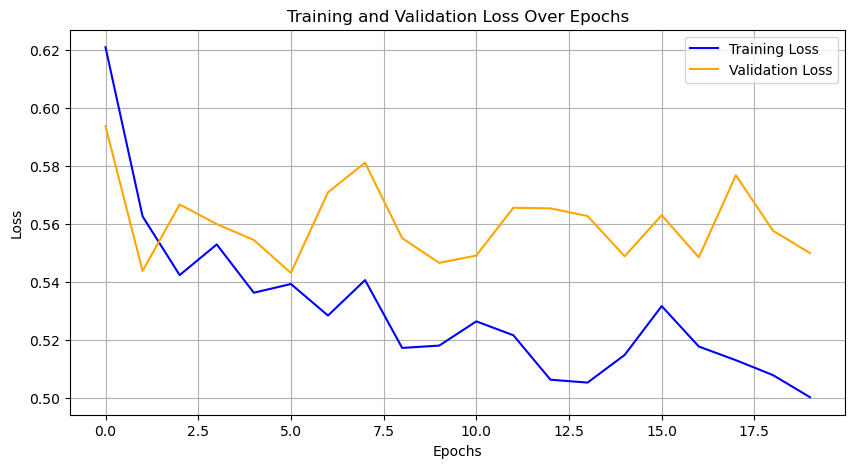

Saving final model...
Model saved to triplet_encoder_final.pth
Training process complete!


In [15]:
"""
Triplet Learning Model for Table Retrieval using FAISS embeddings

This code implements a triplet learning architecture to improve table retrieval.
It trains a neural network to encode query and table embeddings in a way that
semantically related queries and tables are closer together in the embedding space,
while unrelated tables are pushed further apart.
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import json
import numpy as np
import faiss
from typing import Dict, List
from tqdm import tqdm

class FAISSTripletDataset(Dataset):
    """
    Dataset class that loads embeddings directly from FAISS indices
    and maps them to the metadata from the JSON file.
    """
    def __init__(self, metadata_file: str, 
                 query_index_path: str, 
                 positive_index_path: str, 
                 negative_index_path: str):
        print(f"Loading metadata from {metadata_file}...")
        with open(metadata_file, "r") as f:
            self.metadata = json.load(f)
        
        print(f"Loading FAISS indices...")
        self.query_index = faiss.read_index(query_index_path)
        self.positive_index = faiss.read_index(positive_index_path)
        self.negative_index = faiss.read_index(negative_index_path)
        
        print(f"Loading metadata mappings...")
        with open("positive_metadata.json", "r") as f:
            self.positive_metadata = json.load(f)
        with open("negative_metadata.json", "r") as f:
            self.negative_metadata = json.load(f)
        with open("query_metadata.json", "r") as f:
            self.query_metadata = json.load(f)
        
        print("Creating mappings from query IDs to FAISS indices...")
        # Create mappings from qid to index in FAISS
        self.qid_to_query_idx = {}
        for idx, item in enumerate(self.query_metadata):
            self.qid_to_query_idx[item["qid"]] = idx
        
        self.qid_to_pos_idx = {}
        for idx, item in enumerate(self.positive_metadata):
            if item["qid"] not in self.qid_to_pos_idx:
                self.qid_to_pos_idx[item["qid"]] = []
            self.qid_to_pos_idx[item["qid"]].append(idx)
        
        self.qid_to_neg_idx = {}
        for idx, item in enumerate(self.negative_metadata):
            if item["qid"] not in self.qid_to_neg_idx:
                self.qid_to_neg_idx[item["qid"]] = []
            self.qid_to_neg_idx[item["qid"]].append(idx)
        
        # Store list of valid qids (those with query, positive, and negative embeddings)
        self.valid_qids = [qid for qid in self.metadata.keys() 
                          if qid in self.qid_to_query_idx 
                          and qid in self.qid_to_pos_idx 
                          and qid in self.qid_to_neg_idx]
        
        print(f"Dataset ready with {len(self.valid_qids)} valid triplets")

    def __len__(self):
        return len(self.valid_qids)

    def __getitem__(self, idx: int) -> tuple:
        qid = self.valid_qids[idx]
        
        # Get query embedding
        query_idx = self.qid_to_query_idx[qid]
        query_embedding = self._get_vector_from_index(self.query_index, query_idx)
        
        # Get positive embedding
        pos_idx = self.qid_to_pos_idx[qid][0]  # Take the first positive embedding
        pos_embedding = self._get_vector_from_index(self.positive_index, pos_idx)
        
        # Get negative embeddings
        neg_indices = self.qid_to_neg_idx[qid]
        neg_embeddings = [self._get_vector_from_index(self.negative_index, neg_idx) 
                         for neg_idx in neg_indices]
        
        return query_embedding, pos_embedding, neg_embeddings
    
    def _get_vector_from_index(self, index, idx):
        """Get a single vector from a FAISS index by its position."""
        if hasattr(index, 'reconstruct'):
            return index.reconstruct(idx)
        else:
            # For flat indices that don't have reconstruct method
            arr = np.empty((1, index.d), dtype=np.float32)
            index.reconstruct_n(idx, 1, arr)
            return arr[0]
    
    def get_query(self, idx: int) -> str:
        qid = self.valid_qids[idx]
        return self.metadata[qid]["query"]
    
    def get_positive_table_id(self, idx: int) -> str:
        qid = self.valid_qids[idx]
        return self.metadata[qid]["positive_table_id"]
    
    def get_hard_negatives(self, idx: int) -> List[str]:
        qid = self.valid_qids[idx]
        return self.metadata[qid]["hard_negatives"]
    
    def get_positive_content(self, idx: int) -> str:
        qid = self.valid_qids[idx]
        return self.metadata[qid].get("positive_content", "")
    
    def get_negative_contents(self, idx: int) -> List[str]:
        qid = self.valid_qids[idx]
        return self.metadata[qid].get("negative_contents", [])

class TripletEncoder(nn.Module):
    """
    Neural network model that transforms input embeddings into a lower-dimensional space.
    """
    def __init__(self, embedding_dim: int):
        super(TripletEncoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.fc(x)
    
class TripletLoss(nn.Module):
    """
    Custom triplet loss implementation that maximizes the distance between anchor-negative pairs
    while minimizing the distance between anchor-positive pairs.
    """
    def __init__(self, margin: float = 1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        pos_distance = torch.norm(anchor - positive, p=2, dim=1)
        neg_distance = torch.norm(anchor - negative, p=2, dim=1)
        # Triplet loss formula: max(0, distance(anchor, positive) - distance(anchor, negative) + margin)
        losses = torch.clamp(pos_distance - neg_distance + self.margin, min=0.0)
        return losses.mean()
    
class TripletTrainer:
    """
    Trainer class that handles the training and evaluation of the TripletEncoder model.
    """
    def __init__(self, model: nn.Module, train_data: Dataset, val_data: Dataset, batch_size: int = 32, learning_rate: float = 0.001, num_epochs: int = 10, margin: float = 1.0):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = model.to(self.device)
        self.train_data = train_data
        self.val_data = val_data
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.criterion = TripletLoss(margin=margin)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.train_dataloader = DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True, collate_fn=self.collate_fn)
        self.val_dataloader = DataLoader(self.val_data, batch_size=self.batch_size, shuffle=False, collate_fn=self.collate_fn)
        self.train_losses = []
        self.val_losses = []

    def collate_fn(self, batch):
        # Each item in batch is (query_emb, pos_emb, list_of_neg_embs)
        # We select one negative for each positive
        anchors, positives, negatives = [], [], []
        for anchor, positive, neg_embs in batch:
            if neg_embs:  # ensure there is at least one negative
                anchors.append(anchor)
                positives.append(positive)
                # Select a random negative from the list
                negatives.append(neg_embs[np.random.randint(len(neg_embs))])

        if not anchors:
            return None, None, None

        anchors = torch.tensor(np.array(anchors), dtype=torch.float32)
        positives = torch.tensor(np.array(positives), dtype=torch.float32)
        negatives = torch.tensor(np.array(negatives), dtype=torch.float32)
        return anchors, positives, negatives

    def train(self):
        best_val_loss = float('inf')
        for epoch in range(self.num_epochs):
            self.model.train()
            total_train_loss = 0.0
            batch_count = 0
            
            for anchor, positive, negative in tqdm(self.train_dataloader, desc=f"Epoch {epoch+1}/{self.num_epochs} Training"):
                if anchor is None: continue
                anchor, positive, negative = anchor.to(self.device), positive.to(self.device), negative.to(self.device)
                
                self.optimizer.zero_grad()
                
                anchor_embedding = self.model(anchor)
                positive_embedding = self.model(positive)
                negative_embedding = self.model(negative)
                
                loss = self.criterion(anchor_embedding, positive_embedding, negative_embedding)
                loss.backward()
                self.optimizer.step()
                
                total_train_loss += loss.item()
                batch_count += 1

            avg_train_loss = total_train_loss / batch_count if batch_count > 0 else 0
            avg_val_loss = self.validate()

            self.train_losses.append(avg_train_loss)
            self.val_losses.append(avg_val_loss)
            
            print(f"Epoch [{epoch+1}/{self.num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                self.save_model("best_model.pth")
        
        print("Training complete.")
        return best_val_loss, self.train_losses, self.val_losses


    def validate(self):
        self.model.eval()
        total_val_loss = 0.0
        batch_count = 0
        
        with torch.no_grad():
            for anchor, positive, negative in tqdm(self.val_dataloader, desc="Validation"):
                if anchor is None: continue
                anchor, positive, negative = anchor.to(self.device), positive.to(self.device), negative.to(self.device)
                
                anchor_embedding = self.model(anchor)
                positive_embedding = self.model(positive)
                negative_embedding = self.model(negative)
                
                loss = self.criterion(anchor_embedding, positive_embedding, negative_embedding)
                total_val_loss += loss.item()
                batch_count += 1
        
        return total_val_loss / batch_count if batch_count > 0 else 0

    def save_model(self, path: str):
        torch.save(self.model.state_dict(), path)
        print(f"Model saved to {path}")

    def load_model(self, path: str):
        self.model.load_state_dict(torch.load(path, map_location=self.device))
        self.model.eval()
        print(f"Model loaded from {path}")
 
 # a class for plotting the training and validation loss
class TrainingPlotter:
    """
    Class to handle plotting of training and validation loss over epochs.
    """
    def __init__(self):
        self.train_losses = []
        self.val_losses = []

    def update(self, train_loss: float, val_loss: float):
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)

    def plot(self):
        import matplotlib.pyplot as plt
        
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label='Training Loss', color='blue')
        plt.plot(self.val_losses, label='Validation Loss', color='orange')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss Over Epochs')
        plt.legend()
        plt.grid()
        plt.show()

def main():
    """
    Main execution function that handles data loading, model initialization,
    training, and saving the final model for inference.
    """
    print("Starting triplet model training with FAISS embeddings...")
    
    # Step 1: Data Preparation - Load embeddings from FAISS indices
    try:
        triplet_dataset = FAISSTripletDataset(
            metadata_file="triplet_embeddings_data.json",
            query_index_path="/home/mvyas7/TRIM-QA/Summer-Research/queries_index.faiss",
            positive_index_path="/home/mvyas7/TRIM-QA/Summer-Research/positive_tables_index.faiss",
            negative_index_path="/home/mvyas7/TRIM-QA/Summer-Research/negative_tables_index.faiss"
        )
    except Exception as e:
        print(f"Error loading dataset: {e}")
        raise e
    
    # Split dataset into training and validation
    print("Splitting data into training and validation sets...")
    train_size = int(0.8 * len(triplet_dataset))
    val_size = len(triplet_dataset) - train_size
    train_dataset, val_dataset = random_split(triplet_dataset, [train_size, val_size])
    print(f"Training set size: {train_size}, Validation set size: {val_size}")
    
    # Get the embedding dimension from the FAISS index
    embedding_dim = triplet_dataset.query_index.d
    print(f"Embedding dimension from FAISS index: {embedding_dim}")
    
    # Step 2: Model Architecture - Initialize encoder network
    print("Initializing encoder model...")
    model = TripletEncoder(embedding_dim).to('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Step 3 & 4: Loss Function & Training Loop - Initialize trainer with triplet loss
    print("Setting up training parameters...")
    trainer = TripletTrainer(
        model=model, 
        train_data=train_dataset, 
        val_data=val_dataset, 
        batch_size=16, 
        learning_rate=2e-3, # Adjusted learning rate for better convergence
        num_epochs=20,
        margin=1.0  # Hyperparameter defining how far apart positive and negative pairs should be
    )

    # Initialise the plotter
    plotter = TrainingPlotter()

    # Train the model
    print("Beginning model training...")
    best_val_losses, train_losses, val_losses = trainer.train()

    # Update the plotter with training and validation losses
    for train_loss, val_loss in zip(train_losses, val_losses):
        plotter.update(train_loss, val_loss)

    # Plot the training and validation losses
    print("Plotting training and validation losses...")
    plotter.plot()
    
    # Save the trained model for inference
    print("Saving final model...")
    trainer.save_model("triplet_encoder_final.pth")
    print("Training process complete!")

if __name__ == "__main__":
    main()

Loading FAISS indices...
Embedding dimension from FAISS index: 768
Model loaded from triplet_encoder_final.pth
Loading metadata from triplet_embeddings_data.json...
Loading FAISS indices...
Loading metadata mappings...
Creating mappings from query IDs to FAISS indices...
Dataset ready with 9530 valid triplets


Processing embeddings: 100%|██████████| 100/100 [00:00<00:00, 1752.26it/s]

Collected 100 query, 100 positive, and 100 negative embeddings
Applying t-SNE for visualization...


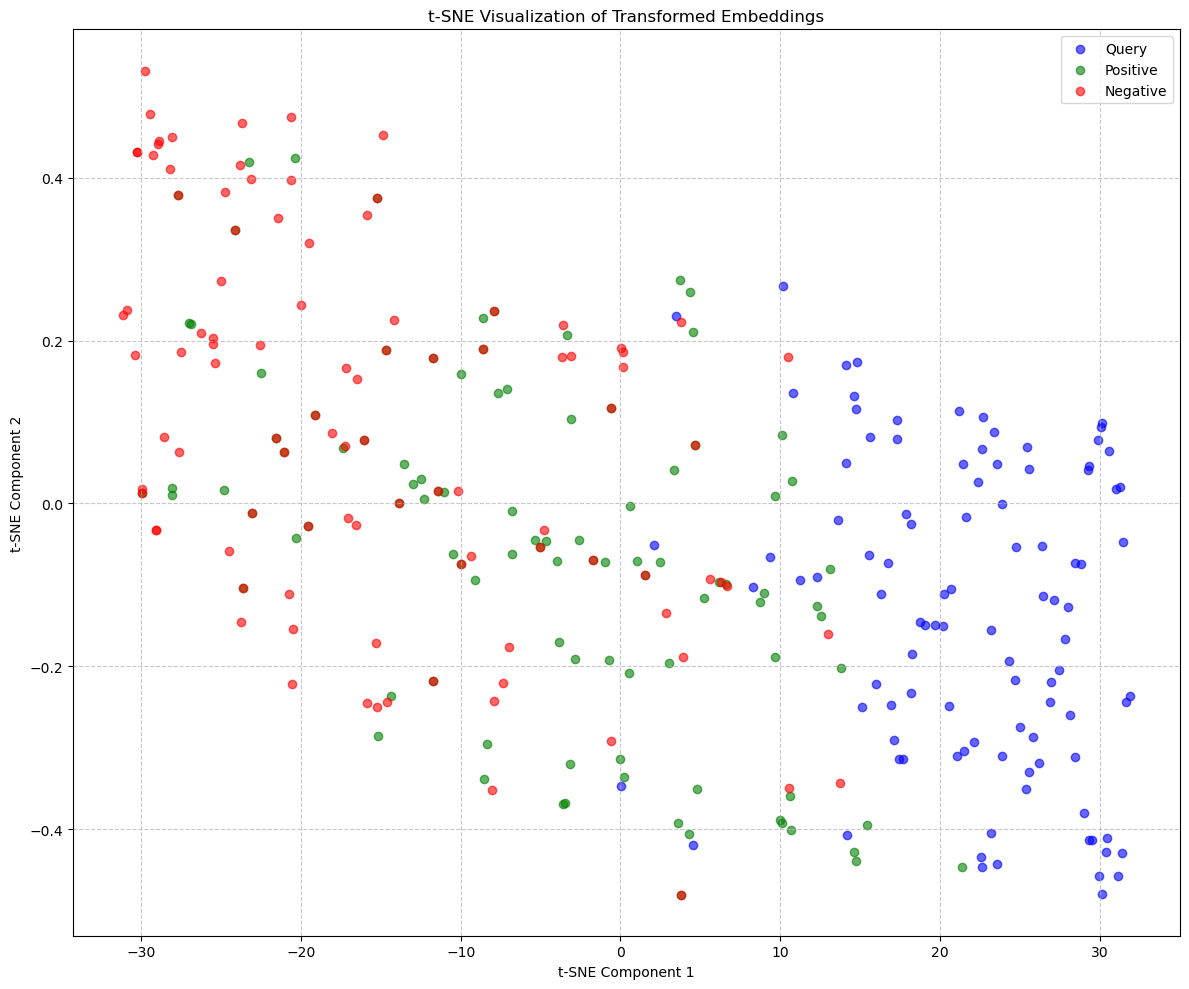

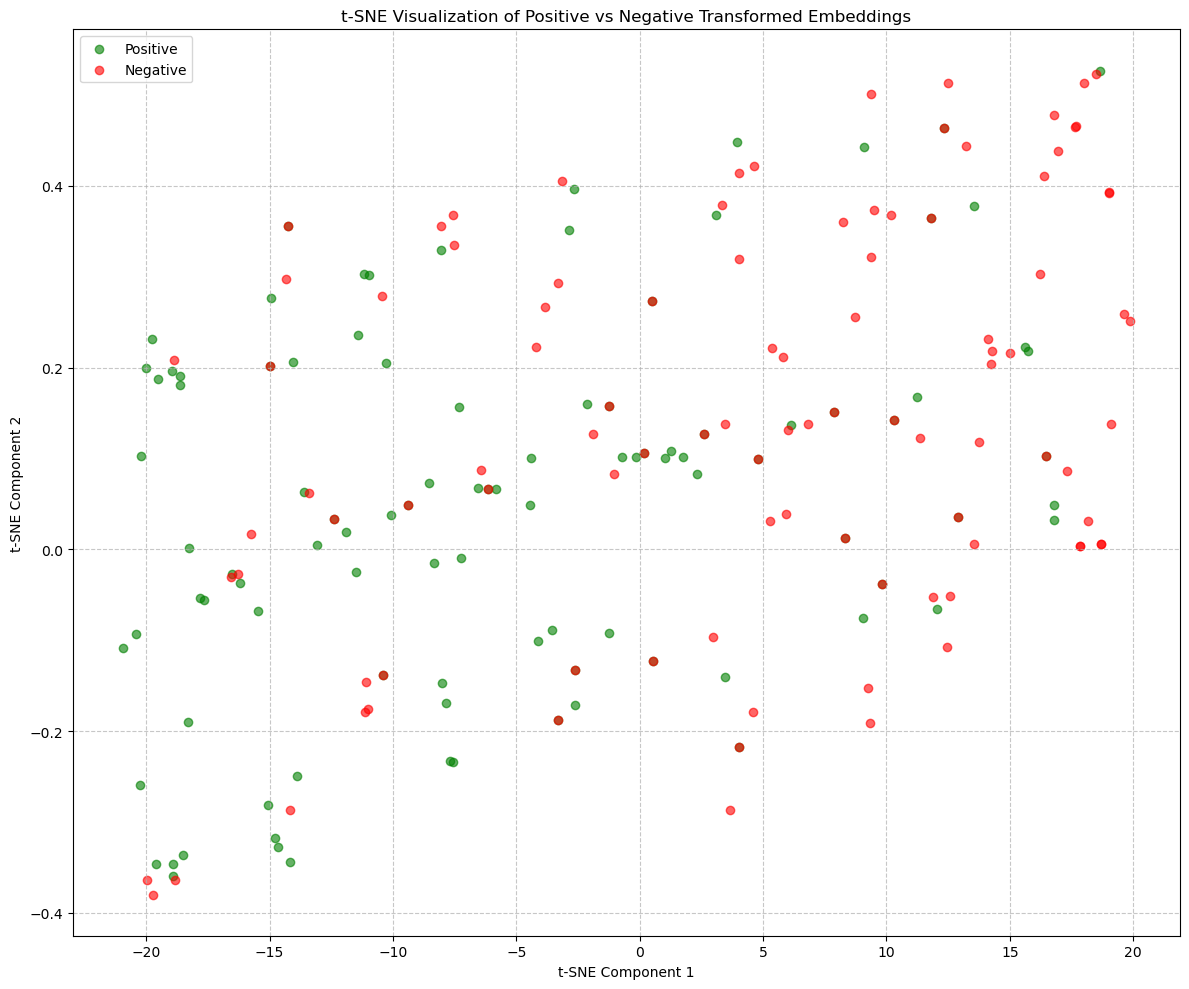

In [16]:
import torch
import numpy as np
import faiss
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import json
from tqdm import tqdm

# Load the trained model
def load_trained_model(model_path, embedding_dim):
    from torch import nn
    
    # Define the model architecture (same as in your training code)
    class TripletEncoder(nn.Module):
        def __init__(self, embedding_dim):
            super(TripletEncoder, self).__init__()
            self.fc = nn.Sequential(
                nn.Linear(embedding_dim, 512),
                nn.ReLU(),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, 128)
            )

        def forward(self, x):
            return self.fc(x)
    
    # Create model instance
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = TripletEncoder(embedding_dim).to(device)
    
    # Load the trained weights
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    return model, device

# Function to get transformed embeddings
def get_transformed_embeddings(model, device, data_loader):
    queries = []
    positives = []
    negatives = []
    
    with torch.no_grad():
        for query_emb, pos_emb, neg_embs_list in tqdm(data_loader, desc="Processing embeddings"):
            # Skip empty batches
            if query_emb is None:
                continue
                
            # Process batch
            query = query_emb.to(device)
            pos = pos_emb.to(device)
            
            # Transform embeddings through the model
            query_transformed = model(query).cpu().numpy()
            pos_transformed = model(pos).cpu().numpy()
            
            queries.append(query_transformed)
            positives.append(pos_transformed)
            
            # Process each negative embedding
            for i, sample_negs in enumerate(neg_embs_list):
                # Take the first negative for simplicity
                if len(sample_negs) > 0:
                    neg = torch.tensor(sample_negs[0], dtype=torch.float32).unsqueeze(0).to(device)
                    neg_transformed = model(neg).cpu().numpy()
                    negatives.append(neg_transformed)
    
    return np.vstack(queries), np.vstack(positives), np.vstack(negatives)

# Visualization script
def visualize_embeddings():
    print("Loading FAISS indices...")
    query_index = faiss.read_index("/home/mvyas7/TRIM-QA/Summer-Research/queries_index.faiss")
    positive_index = faiss.read_index("/home/mvyas7/TRIM-QA/Summer-Research/positive_tables_index.faiss")
    negative_index = faiss.read_index("/home/mvyas7/TRIM-QA/Summer-Research/negative_tables_index.faiss")
    
    embedding_dim = query_index.d
    print(f"Embedding dimension from FAISS index: {embedding_dim}")
    
    # Load the trained model
    model_path = "triplet_encoder_final.pth"  # or "best_model.pth"
    model, device = load_trained_model(model_path, embedding_dim)
    print(f"Model loaded from {model_path}")
    
    # Create dataset and get a sample of embeddings to visualize
    from torch.utils.data import DataLoader, Subset
    from random import sample
    
    # Initialize dataset
    # from FAISSTripletDataset import FAISSTripletDataset  # Import your dataset class
    dataset = FAISSTripletDataset(
        metadata_file="triplet_embeddings_data.json",
        query_index_path="/home/mvyas7/TRIM-QA/Summer-Research/queries_index.faiss",
        positive_index_path="/home/mvyas7/TRIM-QA/Summer-Research/positive_tables_index.faiss",
        negative_index_path="/home/mvyas7/TRIM-QA/Summer-Research/negative_tables_index.faiss"
    )
    
    # Sample subset for visualization (e.g., 100 samples)
    sample_size = min(100, len(dataset))
    indices = sample(range(len(dataset)), sample_size)
    subset = Subset(dataset, indices)
    
    # Create data loader with custom collate function
    def custom_collate_fn(batch):
        return batch  # Return as is, process individually
    
    loader = DataLoader(subset, batch_size=1, shuffle=False, collate_fn=custom_collate_fn)
    
    # Get transformed embeddings
    query_embeddings, positive_embeddings, negative_embeddings = [], [], []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Processing embeddings"):
            for query_emb, pos_emb, neg_embs in batch:
                # Convert to tensors
                query = torch.tensor(query_emb, dtype=torch.float32).to(device)
                pos = torch.tensor(pos_emb, dtype=torch.float32).to(device)
                
                # Transform through model
                query_out = model(query).cpu().numpy()
                pos_out = model(pos).cpu().numpy()
                
                query_embeddings.append(query_out)
                positive_embeddings.append(pos_out)
                
                # Process one negative embedding per triplet
                if neg_embs:
                    neg = torch.tensor(neg_embs[0], dtype=torch.float32).to(device)
                    neg_out = model(neg).cpu().numpy()
                    negative_embeddings.append(neg_out)
    
    # Stack all embeddings
    query_embeddings = np.vstack(query_embeddings)
    positive_embeddings = np.vstack(positive_embeddings)
    negative_embeddings = np.vstack(negative_embeddings)
    
    print(f"Collected {len(query_embeddings)} query, {len(positive_embeddings)} positive, and {len(negative_embeddings)} negative embeddings")
    
    # Combine all embeddings for dimensionality reduction
    all_embeddings = np.vstack([query_embeddings, positive_embeddings, negative_embeddings])
    labels = ['Query'] * len(query_embeddings) + ['Positive'] * len(positive_embeddings) + ['Negative'] * len(negative_embeddings)
    
    # Apply t-SNE for visualization
    print("Applying t-SNE for visualization...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    tsne_result = tsne.fit_transform(all_embeddings)
    
    # Create visualization with 3 classes
    plt.figure(figsize=(12, 10))
    colors = {'Query': 'blue', 'Positive': 'green', 'Negative': 'red'}
    
    for label, color in colors.items():
        mask = [l == label for l in labels]
        plt.scatter(tsne_result[mask, 0], tsne_result[mask, 1], c=color, label=label, alpha=0.6)
    
    plt.title('t-SNE Visualization of Transformed Embeddings')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Also create a version just showing positives vs negatives
    plt.figure(figsize=(12, 10))
    
    # Get just the positives and negatives
    pos_neg_embeddings = np.vstack([positive_embeddings, negative_embeddings])
    pos_neg_labels = ['Positive'] * len(positive_embeddings) + ['Negative'] * len(negative_embeddings)
    
    # Apply t-SNE again for just positives and negatives
    tsne_pos_neg = TSNE(n_components=2, random_state=42, perplexity=30)
    tsne_result_pos_neg = tsne_pos_neg.fit_transform(pos_neg_embeddings)
    
    # Plot
    for label, color in {'Positive': 'green', 'Negative': 'red'}.items():
        mask = [l == label for l in pos_neg_labels]
        plt.scatter(tsne_result_pos_neg[mask, 0], tsne_result_pos_neg[mask, 1], c=color, label=label, alpha=0.6)
    
    plt.title('t-SNE Visualization of Positive vs Negative Transformed Embeddings')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    visualize_embeddings()